In [2]:
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt

## Data Loading and Preprocessing

In [3]:
with open("compiled.txt", "r") as file:
    lines = file.readlines()

processed_lines = []
for line in lines:
    parts = line.split(",", 2)
    if len(parts) > 2:
        parts[2] = parts[2].replace(",", "~")
    processed_lines.append(",".join(parts))

with open("processed_compiled.txt", "w") as file:
    file.writelines(processed_lines)

df = pd.read_csv(
    "processed_compiled.txt",
    names=["doc", "date", "description"],
    usecols=[0, 1, 2],
    engine="python",
    sep=","
)

df["description"] = df["description"].replace("~", ",", regex=True)
df = df.drop(0, axis=0).reset_index(drop=True)



In [4]:
df["date"] = df["date"].fillna("NA").str.strip()

def safe_split(x):
    if x != "NA" and len(x.split(" ")) == 3:
        return x.split(" ")
    else:
        return [None, None, None]

split_dates = df["date"].apply(safe_split)

df["Month"], df["Day"], df["Year"] = zip(*split_dates)

df["Month"] = df["Month"].str.replace(r'\.$', '', regex=True)
df["Day"] = df["Day"].str.replace(r'\D', '', regex=True)
df['Year'] = pd.to_numeric(df['Year'], errors='coerce').fillna(0).astype(int)




In [5]:
def preprocess(text):
    if isinstance(text, str):
        text = text.lower()
        text = re.sub(r'[^\w\s]', '', text)
        return text
    return ''

df['clean_description'] = df['description'].apply(preprocess)


## Crime Type Classification

In [6]:

categories = {
    "Private Trade": [
        "private trader", "private trade", "brought home", "landing goods", "carried out",
        "conveyed", "freight", "renvoyed", "great trade", "smuggled", "undeclared",
        "private account", "private trade", "damage the price", "private men's goods", 
        "sent up before the Company's", "Company's return of private trade", "goods carried", 
        "goods for his own account", "private trade from Persia", "landed goods"
    ],
    "Financial Misconduct": [
        "lavish expenses", "embezzling", "undervalue", "making desperate debts",
        "wasteful expense", "defalked", "fined", "connivance", "confiscated", "debt", 
        "extravagant expenses", "prodiligy", "taking up money on the Company's credit", 
        "maintenance of private women", "indebted", "personal use", "purchase of goods",
        "invested in private trade", "improper clearances"
    ],
    "Negligence & Misconduct": [
        "questioned", "complained of", "irregular", "insufficiency", "faulty",
        "displaced", "blamed", "suspended", "lazy", "insubordinate", "discharged", 
        "improper behavior", "carelessness", "refused", "disrespectful"
    ],
    "Smuggling & Illegal Goods": [
        "brought home", "kept", "renvoyed", "smuggled", "carried out", "hidden",
        "undeclared", "confiscated", "seized at Bantam", "landed out of the ship", 
        "undocumented", "concealed"
    ],
    "Bribery & Corruption": [
        "ransom", "gave them costly apparel", "favoritism", "connivance", "graft", 
        "bribe", "kickbacks", "unjust treatment", "misuse of power", "collusion"
    ],
    "Drunkenness & Disorderly Conduct": [
        "drunkenness", "excess of drinking", "extraordinary drinking",
        "intoxicated", "disorderly", "debauched", "idle", "lazy", "drinking immoderately", 
        "spent time in wantonness", "fell out with", "engaged in fray", "carried away with wine"
    ],
    "Abuse of Authority": [
        "kept women", "refused ransom", "misuse of power", "cruelty", "harsh punishment",
        "tyranny", "unjust treatment", "imperious", "disobedience", "failure to account", 
        "overstepping authority"
    ],
    "Fraud & False Documentation": [
        "false ticket", "forgery", "improper wanting", "counterfeit",
        "fraudulent claims", "fabricated", "misrepresentation", "false weight", "false journals"
    ],
    "Theft & Embezzlement": [
        "embezzling", "stolen", "took", "kept", "gold", "defrauded",
        "pilfered", "misappropriated", "looted", "stolen goods", "wrongfully taken", 
        "unaccounted for", "seized by others"
    ],
    "Murder & Violence": [
        "put to death", "killed", "murdered", "violence", "assault",
        "mutiny", "executed", "death", "slain", "fell out with", "fray", "disorder"
    ],
    "Shipwreck & Navigation Errors": [
        "casting away", "wrecked", "stranded", "sank", "grounded",
        "lost at sea", "sunk", "negligence in navigation", "navigation error", "careless shooting"
    ],
    "Misuse of Company Resources": [
        "lavish expenditure", "extravagance", "company's credit", "private trade use", 
        "personal gain", "misuse of resources", "using company for private purposes", 
        "spending for personal benefit"
    ]
}

def categorize_crime(description, categories):
    for category, keywords in categories.items():
        if any(keyword in description for keyword in keywords):
            return category
    return "Other"

df['crime_category'] = df['clean_description'].apply(lambda x: categorize_crime(x, categories))

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 [Text(0, 0, 'Other'),
  Text(1, 0, 'Private Trade'),
  Text(2, 0, 'Financial Misconduct'),
  Text(3, 0, 'Negligence & Misconduct'),
  Text(4, 0, 'Theft & Embezzlement'),
  Text(5, 0, 'Murder & Violence'),
  Text(6, 0, 'Smuggling & Illegal Goods'),
  Text(7, 0, 'Shipwreck & Navigation Errors'),
  Text(8, 0, 'Fraud & False Documentation'),
  Text(9, 0, 'Drunkenness & Disorderly Conduct'),
  Text(10, 0, 'Abuse of Authority'),
  Text(11, 0, 'Bribery & Corruption')])

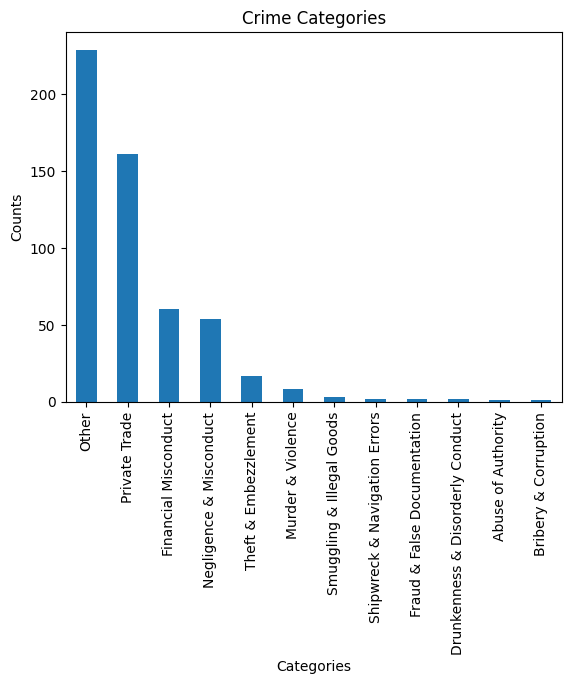

In [16]:
df["crime_category"].value_counts().plot(kind="bar")
plt.title("Crime Categories")
plt.xlabel("Categories")
plt.ylabel("Counts")
plt.xticks(rotation=90)


In [8]:
crime_counts = df.groupby(['Year', 'crime_category']).size().reset_index(name='count')

In [9]:
crime_counts = crime_counts[crime_counts["Year"] > 0]

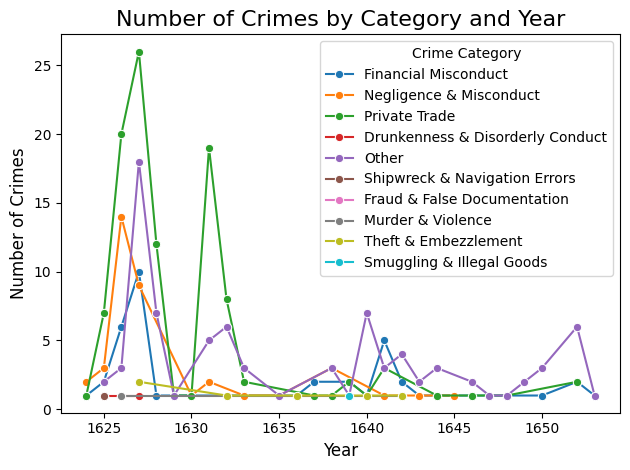

In [10]:

sns.lineplot(data=crime_counts, x='Year', y='count', hue='crime_category', marker='o')

plt.title('Number of Crimes by Category and Year', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Crimes', fontsize=12)
plt.legend(title='Crime Category', fontsize=10)

plt.tight_layout()
plt.show()

## Crime Severity Classification

In [11]:
major_keywords = [
    "murder", "violence", "assault", "embezzling", "embezzlement", "mutiny", "execution", "death",
    "ransom", "fraudulent", "theft", "stolen", "defrauded"
]

minor_keywords = [
    "drunkenness", "idle", "lazy", "suspended", "complained of", "faulty", "blamed", "insubordinate",
    "discharged", "disorderly", "improper", "wasteful", "negligence", "excessive drinking", "questioned"
]

In [12]:
def classify_offense(description):

    if description == None or type(description) != str:
        return "None"
    major_found = any(keyword in description.lower() for keyword in major_keywords)
    minor_found = any(keyword in description.lower() for keyword in minor_keywords)
    
    if major_found:
        return "Major Offense"
    elif minor_found:
        return "Minor Offense"
    else:
        return "Unclassified"

In [13]:
df['offense_type'] = df['description'].apply(classify_offense)

<Axes: xlabel='offense_type'>

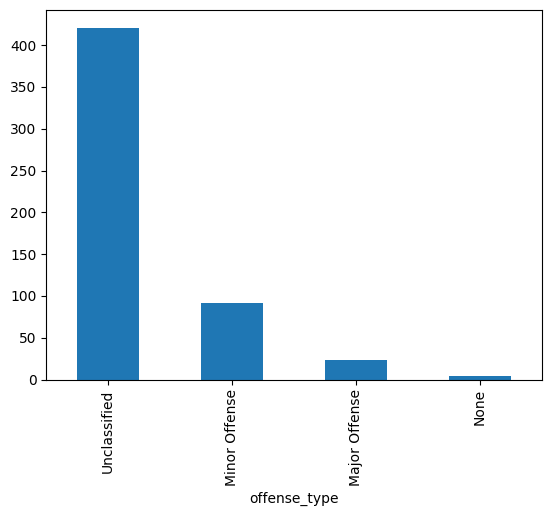

In [14]:
df["offense_type"].value_counts().plot(kind="bar")